<a href="https://colab.research.google.com/github/shinbad/net_project/blob/main/INS_IDS_Paper_Implementation_DLML%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'nfuqnidsv2-network-intrusion-detection-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2176461%2F3632763%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240420%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240420T084403Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D961517517dbfe87ed983e76b21477fce4a6d09985f2c174d0105660031c0af64ad63b27b5e5d76cdea605f025e830d4280f55179864ad2a24cde7d3c2d0fa2137f4ef5ba233dfa8fb2522be314c9bf11593f94588f3e7537df6afa619d7ba01c7950ee9d8d282fddc3992383d09d3c3877a47bcad772ad7a7697eabfad2a588af78b884aa0fbbab8c5b7b59fd14cddf2b5ce4348c140858f2e600177b8a8e857d085ad883564769ee0aac7bee2bc8d7c37f8e593d5367b2f5c19730fcee655b11a65d50128582c8fad62a6ae7e6730522dddc3a54b78526fde91c1d49466c3c25711a35cdf639ad79bb37576083f1694321ca594cfa76f71d091a471b4ac96dc'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2185336021 bytes downloaded
Downloaded and uncompressed: nfuqnidsv2-network-intrusion-detection-dataset
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nfuqnidsv2-network-intrusion-detection-dataset/NF-UQ-NIDS-v2.csv


### Dataset Import

In [ ]:
# , usecols = ['IPV4_SRC_ADDR','L4_SRC_PORT','IPV4_DST_ADDR','L4_DST_PORT','PROTOCOL','L7_PROTO','IN_BYTES','IN_PKTS','OUT_BYTES','OUT_PKTS','TCP_FLAGS','CLIENT_TCP_FLAGS','SERVER_TCP_FLAGS','FLOW_DURATION_MILLISECONDS','DURATION_IN','MIN_TTL','MAX_TTL','LONGEST_FLOW_PKT','SHORTEST_FLOW_PKT','MIN_IP_PKT_LEN','MAX_IP_PKT_LEN','SRC_TO_DST_SECOND_BYTES','DST_TO_SRC_SECOND_BYTES','SRC_TO_DST_AVG_THROUGHPUT','DST_TO_SRC_AVG_THROUGHPUT','NUM_PKTS_UP_TO_128_BYTES','TCP_WIN_MAX_IN','TCP_WIN_MAX_OUT','ICMP_TYPE','ICMP_IPV4_TYPE','DNS_QUERY_ID','DNS_QUERY_TYPE','DNS_TTL_ANSWER','FTP_COMMAND_RET_CODE','Label','Attack']
df = pd.read_csv('/kaggle/input/nfuqnidsv2-network-intrusion-detection-dataset/NF-UQ-NIDS-v2.csv',chunksize=1000000)

In [ ]:
df1 = pd.DataFrame(df.get_chunk(200000))

In [ ]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
srcaddr= LE.fit_transform(df1['IPV4_SRC_ADDR'])
df1['IPV4_SRC_ADDR'] = pd.Series(srcaddr)

In [ ]:
dstaddr= LE.fit_transform(df1['IPV4_DST_ADDR'])
df1['IPV4_DST_ADDR'] = pd.Series(dstaddr)

### Binary Normal-Anomaly (Attack) Detection

In [ ]:
X = df1.drop(['Attack','Label','Dataset'], axis=1)
Y = df1["Label"]

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

X_object = X.select_dtypes("object")
X_int = X.select_dtypes(exclude = "object")

X_columns = X_int.columns

imputer.fit(X_int)
X_int = imputer.transform(X_int)
X_int = pd.DataFrame(X_int)
X_int.columns = X_columns

X_object = X_object.fillna("unknown")
X = X_object.join(X_int)

In [ ]:
X.describe()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,...,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05,200000.000000,2.000000e+05,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.00000,2.000000e+05,200000.00000
mean,2666.863070,40405.227935,1052.972650,3328.118850,10.245175,53.455710,9.943073e+02,9.319455,3.534957e+03,4.906615,...,0.446460,2.288780,5991.116640,8375.737975,3760.923315,14.691100,4505.056320,1.34661,2.240771e+04,1.49466
std,711.324722,18428.567406,333.389975,10654.046022,5.734170,78.994822,8.414777e+04,538.257158,3.219104e+05,224.197938,...,77.296376,218.203822,13174.487031,17701.404959,11539.143748,45.074776,13333.967311,9.58516,9.603748e+06,20.09393
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000e+00,1.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.00000
25%,2803.000000,27270.750000,1062.000000,80.000000,6.000000,0.000000,5.600000e+01,1.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.00000
50%,2816.000000,45737.500000,1147.000000,80.000000,6.000000,7.000000,1.120000e+02,2.000000,0.000000e+00,0.000000,...,0.000000,0.000000,512.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.00000
75%,2818.000000,55084.000000,1149.000000,443.000000,17.000000,92.000000,2.800000e+02,3.000000,1.500000e+02,1.000000,...,0.000000,0.000000,4096.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.00000
max,5273.000000,65535.000000,3196.000000,65535.000000,253.000000,245.000000,3.464156e+07,108222.000000,1.235906e+08,82694.000000,...,34443.000000,82289.000000,65535.000000,65535.000000,65280.000000,255.000000,65529.000000,255.00000,4.294916e+09,530.00000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Correlation Map for Feature Engineering

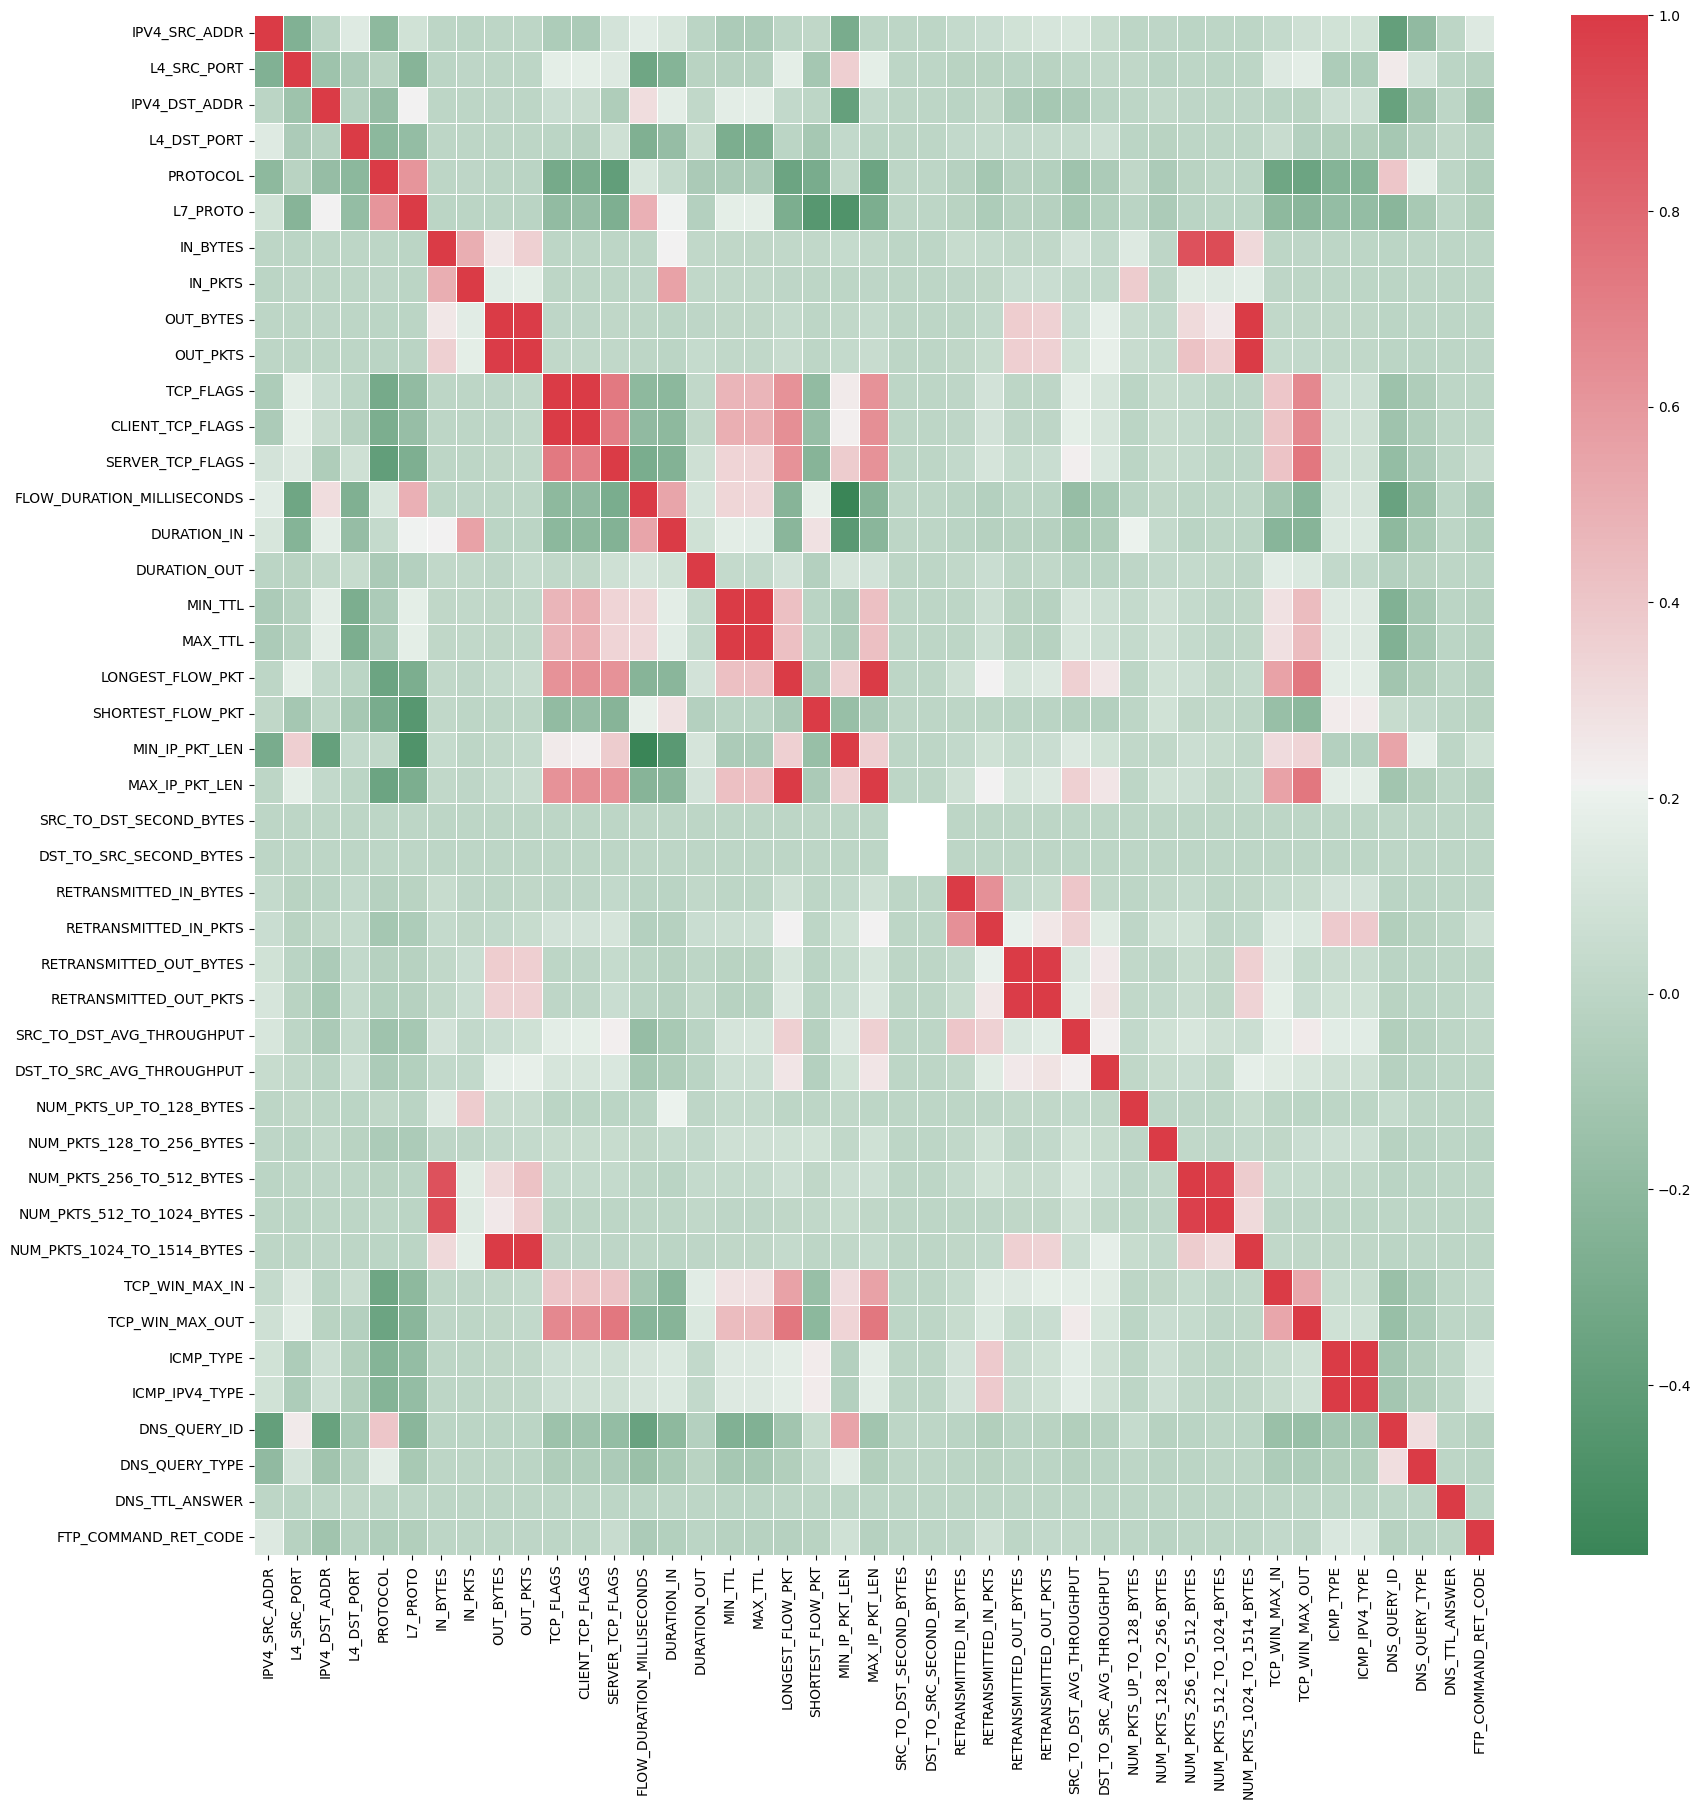

In [ ]:
plt.figure(figsize = (20,20))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
attrb_reln = sns.heatmap(X.corr(),linewidths=0.5, cmap=cmap)
plt.savefig('correlations_dataset.jpg', dpi=1000)

Feature Correlation with Target variable ( Binary Class - Attack Detection )

In [ ]:
corr_with_target = X.corrwith(Y).apply(abs)
df_corr_w_tgt = pd.DataFrame(corr_with_target)
df_corr_w_tgt.to_csv('Feature_Corr_w_Target.csv')

In [ ]:
class LabelEncoderExt(object):
    def __init__(self):
        self.label_encoder = LabelEncoder()

    def fit(self, data):
        self.label_encoder = self.label_encoder.fit(list(data) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_
        return self

    def transform(self, data):
        new_data = list(data)
        for unique_item in np.unique(data):
            if unique_item not in self.label_encoder.classes_:
                new_data = ['Unknown' if x==unique_item else x for x in new_data]
        return self.label_encoder.transform(new_data)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
# store the columns
cols = X_train.columns

# transform the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns = cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = cols)

In [ ]:
X_train_scaled.columns

Index(['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT',
       'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS',
       'TCP_FLAGS', 'CLIENT_TCP_FLAGS', 'SERVER_TCP_FLAGS',
       'FLOW_DURATION_MILLISECONDS', 'DURATION_IN', 'DURATION_OUT', 'MIN_TTL',
       'MAX_TTL', 'LONGEST_FLOW_PKT', 'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN',
       'MAX_IP_PKT_LEN', 'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES',
       'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS',
       'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS',
       'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT',
       'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES',
       'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES',
       'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT',
       'ICMP_TYPE', 'ICMP_IPV4_TYPE', 'DNS_QUERY_ID', 'DNS_QUERY_TYPE',
       'DNS_TTL_ANSWER', 'FTP_COMMAND_RET_CODE'],
      dtype='object')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

rfc.fit(X_train_scaled, y_train)

feature_imp = pd.DataFrame({'Importance':rfc.feature_importances_,'feature':X_train.columns})
feature_imp = feature_imp.sort_values('Importance',ascending=False).set_index('feature')

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

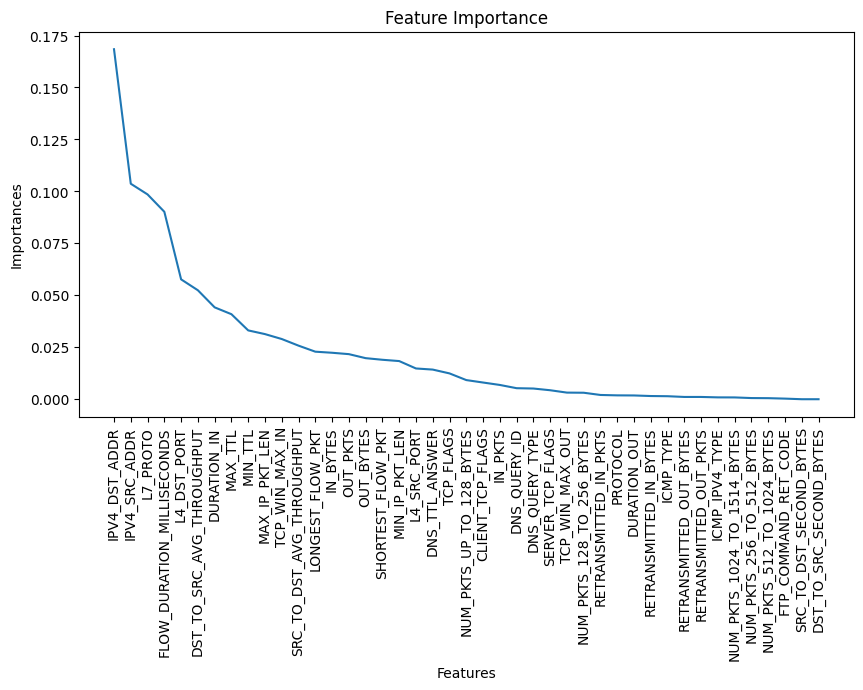

In [ ]:
plt.figure(figsize = (10, 5))
plt.title("Feature Importance", fontname="Times New Roman")
plt.ylabel("Importances")
plt.xlabel("Features")
plt.xticks(rotation=90)
plt.plot(feature_imp)
plt.savefig('feature_importance.jpg', bbox_inches='tight' , dpi=900)

In [ ]:
from sklearn.feature_selection import RFE
estimator = RandomForestClassifier()
selector = RFE(estimator)
selector.fit(X_train_scaled, y_train)

X_train_scaled = selector.transform(X_train_scaled)
X_test_scaled = selector.transform(X_test_scaled)

In [ ]:
from sklearn import datasets, metrics, tree, svm, neighbors
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.tree import DecisionTreeClassifier

from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.neighbors import NearestCentroid

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
SEED = 42

# Decision Tree Model
#dtc = DecisionTreeClassifier()

# SVC MODEL
#from sklearn.svm import SVC
#svc = SVC(random_state = SEED)

# LOGISTIC REGRESSION MODEL
#from sklearn.linear_model import LogisticRegression
#lr = LogisticRegression()

# GAUSSIAN NAIVE BAYES
#gnb = GaussianNB()

# BERNOULLI NAIVE BAYES
#bnb = BernoulliNB()

# Train RandomForestClassifier
#rfe = RandomForestClassifier(max_depth=6)

# Train XGBOOST Classifier
#from xgboost import XGBClassifier
#xgbc = XGBClassifier(eval_metric="logloss", random_state=SEED)

# Train LightGBM Classifier
from lightgbm import LGBMClassifier
lgbmc = LGBMClassifier(random_state=SEED)

# Train Gradient-Boosting Classifier
#grb = GradientBoostingClassifier(learning_rate=1.1)

In [ ]:
from sklearn.model_selection import cross_val_score
models = {}
# models['SVC']= svc
# models['LogisticRegression']= lr
#models['DecisionTreeClassifier']= dtc
#models['Gaussian Naive Bayes Classifier']= gnb
#models['Bernoulli Naive Bayes Classifier']= bnb
#models['Gradient Boosting Classifier']= grb
#models['Random Forest Classifier']= rfe
#models['XGBoost Classifier']= xgbc
models['LightGBM Classifier']= lgbmc
scores = {}
for name in models:
  scores[name]={}
  for scorer in ['precision','recall']:
    scores[name][scorer] = cross_val_score(models[name], X_train_scaled, y_train, cv=3, scoring=scorer)

[LightGBM] [Info] Number of positive: 62616, number of negative: 30717
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3969
[LightGBM] [Info] Number of data points in the train set: 93333, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.670888 -> initscore=0.712205
[LightGBM] [Info] Start training from score 0.712205
[LightGBM] [Info] Number of positive: 62617, number of negative: 30716
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3891
[LightGBM] [Info] Number of data points in the train set: 93333, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.670899 -> initscore=0.712253
[Ligh

In [ ]:
def line(name):
  return '*'*(25-len(name)//2)

for name in models:
  print(line(name), name, 'Model Validation', line(name))

  for scorer in ['precision','recall']:
    mean = round(np.mean(scores[name][scorer])*100,2)
    stdev = round(np.std(scores[name][scorer])*100,2)
    print ("Mean {}:".format(scorer),"\n", mean,"%", "+-",stdev)
    print()

**************** LightGBM Classifier Model Validation ****************
Mean precision: 
 99.7 % +- 0.02

Mean recall: 
 99.69 % +- 0.02



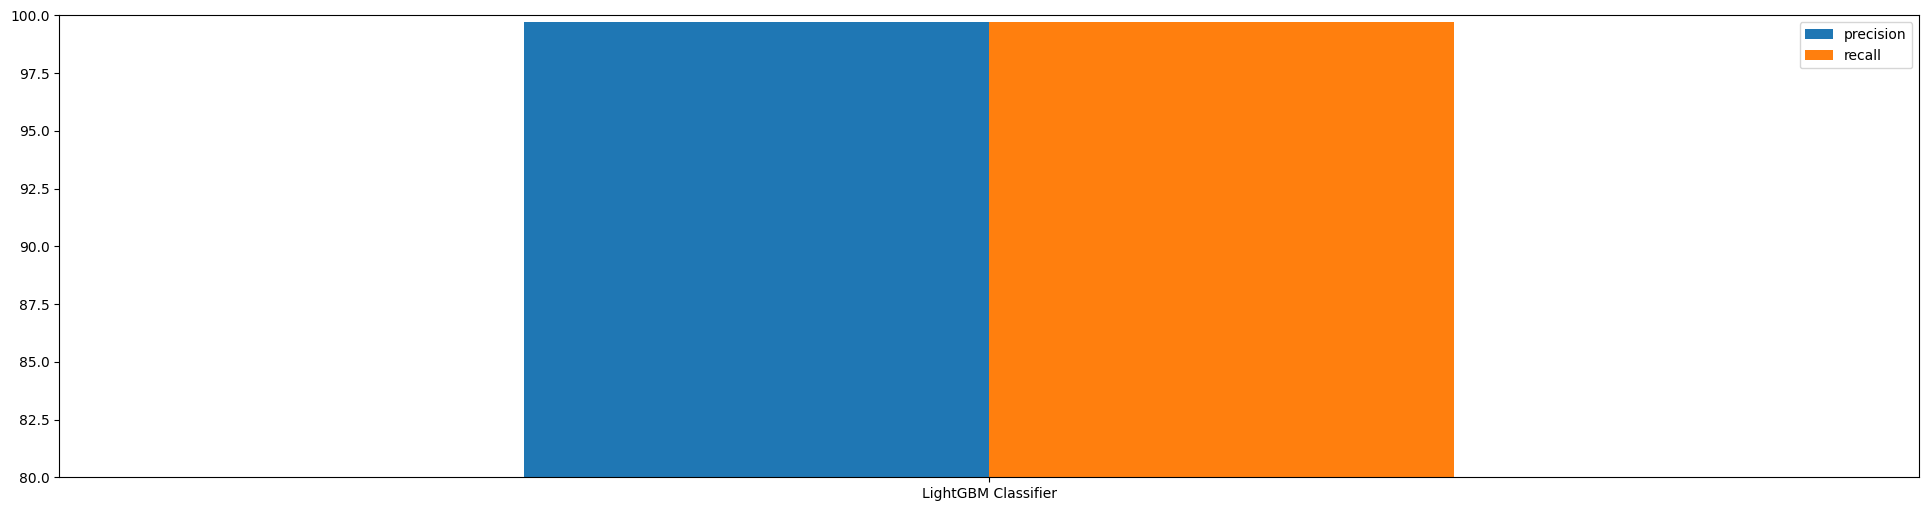

In [ ]:
for name in models:
    for scorer in ['precision','recall']:
        scores[name][scorer] = scores[name][scorer].mean()
scores=pd.DataFrame(scores).swapaxes("index", "columns")*100
scores.plot(kind = "bar",  ylim=[80,100], figsize=(24,6), rot=0)
plt.savefig('precision-recall.png', bbox_inches='tight')

In [ ]:
models = {}
#models['SVC']= svc
#models['LogisticRegression']= lr
#models['DecisionTreeClassifier']= dtc
#models['Gaussian Naive Bayes Classifier']= gnb
#models['Bernoulli Naive Bayes Classifier']= bnb
#models['Gradient Boosting Classifier']= grb
#models['Random Forest Classifier']= rfe
#models['XGBoost Classifier']= xgbc
models['LightGBM Classifier']= lgbmc
preds={}
for name in models:
    models[name].fit(X_train_scaled, y_train)
    preds[name] = models[name].predict(X_test_scaled)
#     cfm_plot = plot_confusion_matrix(models[name], X_train_scaled, y_train)
#     cfm_plot.savefig("cfm_"+name+".png")
print("Predictions complete.")

[LightGBM] [Info] Number of positive: 93925, number of negative: 46075
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4072
[LightGBM] [Info] Number of data points in the train set: 140000, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.670893 -> initscore=0.712226
[LightGBM] [Info] Start training from score 0.712226
Predictions complete.


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
def line(name,sym="*"):
    return sym*(25-len(name)//2)
target_names=["normal","anamoly"]
for name in models:
    print(line(name), name, 'Model Testing', line(name))
    print(confusion_matrix(y_test, preds[name]))
    print(line(name,'-'))
    print(classification_report(y_test, preds[name], target_names=target_names))

**************** LightGBM Classifier Model Testing ****************
[[19575   115]
 [  131 40179]]
----------------
              precision    recall  f1-score   support

      normal       0.99      0.99      0.99     19690
     anamoly       1.00      1.00      1.00     40310

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000



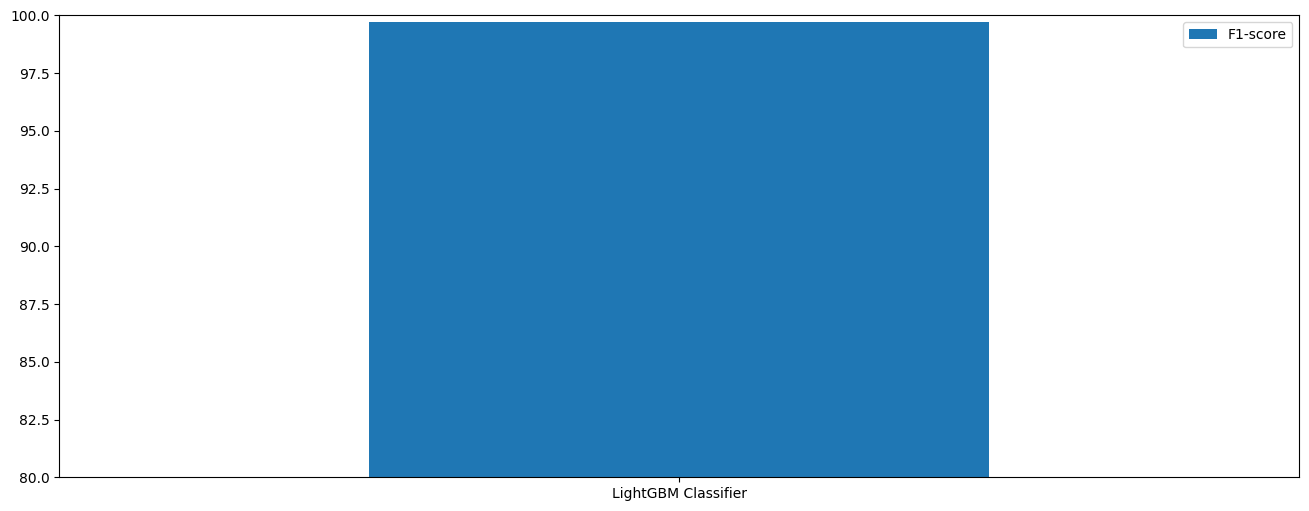

In [ ]:
f1s = {}
for name in models:
    f1s[name]=f1_score(y_test, preds[name])
f1s=pd.DataFrame(f1s.values(),index=f1s.keys(),columns=["F1-score"])*100
f1s.plot(kind = "bar",  ylim=[80,100], figsize=(16,6), rot=0)
plt.savefig('f1-score.png', bbox_inches='tight')

### Multi-Class Intrusion type detection : Intrusion type detection for attack type increases system complexity

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
X1 = df1.drop(['Attack','Label','Dataset'], axis=1)
Y1 = df1["Attack"]

In [ ]:
LE = LabelEncoder()
multilbl = LE.fit_transform(Y1)
Y1 = pd.Series(multilbl)

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

X1_object = X1.select_dtypes("object")
X1_int = X1.select_dtypes(exclude = "object")

X1_columns = X1_int.columns

imputer.fit(X1_int)
X1_int = imputer.transform(X1_int)
X1_int = pd.DataFrame(X1_int)
X1_int.columns = X1_columns

X1_object = X1_object.fillna("unknown")
X1 = X1_object.join(X1_int)

In [ ]:
from sklearn.model_selection import train_test_split
# from skmultilearn.model_selection import iterative_train_test_split
# X_train_1, X_test_1, y_train_1, y_test_1 = iterative_train_test_split(X1, Y1, test_size = 0.5)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X1, Y1, test_size=0.3, random_state=42)

In [ ]:
# y_train_1의 클래스 수를 파악합니다.
num_classes = len(set(y_train_1))

# LightGBM Classifier를 생성할 때 objective를 'multiclass'로 설정하고, num_class를 지정합니다.
lgbmc = LGBMClassifier(objective='multiclass', num_class=num_classes, random_state=SEED)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
# store the columns
cols = X_train_1.columns

# transform the data
X_train_scaled_1 = scaler.fit_transform(X_train_1)
X_test_scaled_1 = scaler.transform(X_test_1)

X_train_scaled_1 = pd.DataFrame(X_train_scaled_1, columns = cols)
X_test_scaled_1 = pd.DataFrame(X_test_scaled_1, columns = cols)

In [ ]:
print(lgbmc)

LGBMClassifier(num_class=21, objective='multiclass', random_state=42)


In [ ]:
models_1 = {}
#models_1['SVC']= svc
#models_1['LogisticRegression']= lr
#models_1['DecisionTreeClassifier']= dtc
#models_1['Gaussian Naive Bayes Classifier']= gnb
#models_1['Bernoulli Naive Bayes Classifier']= bnb
#models_1['Gradient Boosting Classifier']= grb
#models_1['Random Forest Classifier']= rfe
#models_1['XGBoost Classifier']= xgbc
models_1['LightGBM Classifier']= lgbmc
preds_1={}
modelAcc_1={}
for name in models_1:
    models_1[name].fit(X_train_scaled_1, y_train_1)
    preds_1[name] = models_1[name].predict(X_test_scaled_1)
    modelAcc_1[name] = accuracy_score(y_test_1, preds_1[name])
#     cfm_plot = plot_confusion_matrix(models[name], X_train_scaled, y_train)
#     cfm_plot.savefig("cfm_"+name+".png")
print("Predictions complete.")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6561
[LightGBM] [Info] Number of data points in the train set: 140000, number of used features: 41
[LightGBM] [Info] Start training from score -10.750785
[LightGBM] [Info] Start training from score -8.160518
[LightGBM] [Info] Start training from score -1.111372
[LightGBM] [Info] Start training from score -6.269668
[LightGBM] [Info] Start training from score -6.319969
[LightGBM] [Info] Start training from score -1.249269
[LightGBM] [Info] Start training from score -1.442472
[LightGBM] [Info] Start training from score -7.879106
[LightGBM] [Info] Start training from score -8.352890
[LightGBM] [Info] Start training from score -8.853665
[LightGBM] [Info] Start training from score -6.516679
[LightGBM] [Info] Start training from score -3.3657

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
def line(name,sym="*"):
    return sym*(25-len(name)//2)
for name in models_1:
    print(line(name), name, 'Model Testing', line(name))
    print(confusion_matrix(y_test_1, preds[name]))
    print(line(name,'-'))
    print(classification_report(y_test_1, preds_1[name]))

**************** LightGBM Classifier Model Testing ****************
[[    0     4     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]
 [    0    12     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]
 [19575   115     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]
 [    0   106     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]
 [    0    92     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]
 [    5 17360     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]
 [    2 14177     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]
 [    3    21     0     0     0     0     0     0     0  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
for name in models_1:
  modelAcc_1[name] = accuracy_score(y_test_1, preds_1[name])
  print(name, ':', modelAcc_1[name])

SVC : 0.9332
LogisticRegression : 0.8614833333333334
DecisionTreeClassifier : 0.9861666666666666
Gaussian Naive Bayes Classifier : 0.5992
Bernoulli Naive Bayes Classifier : 0.5425
Gradient Boosting Classifier : 0.08261666666666667
Random Forest Classifier : 0.94645
XGBoost Classifier : 0.9893333333333333


In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import pandas as pd

models_2={'LightGBM Classifier' : lgbmc}

evaluation_results = {}

for name, model in models_2.items():
    # 모델 학습
    model.fit(X_train_scaled_1, y_train_1)

    # 예측
    preds = model.predict(X_test_scaled_1)

    # 정확도 계산
    accuracy = accuracy_score(y_test_1, preds)

    # precision, recall, f1-score 계산
    precision, recall, f1_score, support = precision_recall_fscore_support(y_test_1, preds, average='weighted')

    # 결과를 딕셔너리에 저장
    evaluation_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    }

# 결과를 데이터 프레임으로 변환
df_results = pd.DataFrame(evaluation_results).T

# 결과 출력
print(df_results)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6561
[LightGBM] [Info] Number of data points in the train set: 140000, number of used features: 41
[LightGBM] [Info] Start training from score -10.750785
[LightGBM] [Info] Start training from score -8.160518
[LightGBM] [Info] Start training from score -1.111372
[LightGBM] [Info] Start training from score -6.269668
[LightGBM] [Info] Start training from score -6.319969
[LightGBM] [Info] Start training from score -1.249269
[LightGBM] [Info] Start training from score -1.442472
[LightGBM] [Info] Start training from score -7.879106
[LightGBM] [Info] Start training from score -8.352890
[LightGBM] [Info] Start training from score -8.853665
[LightGBM] [Info] Start training from score -6.516679
[LightGBM] [Info] Start training from score -3.3657

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import pandas as pd

# 다양한 모델을 저장한 딕셔너리
models_1 = {
    'SVC': svc,
    'LogisticRegression': lr,
    'DecisionTreeClassifier': dtc,
    'Gaussian Naive Bayes Classifier': gnb,
    'Bernoulli Naive Bayes Classifier': bnb,
    'Gradient Boosting Classifier': grb,
    'Random Forest Classifier': rfe,
    'XGBoost Classifier': xgbc
}

models_2={'LightGBM Classifier' : lgbmc}

# 모델 예측 결과 및 평가 지표를 저장할 딕셔너리
evaluation_results = {}

# 각 모델에 대해 예측을 수행하고 평가 지표를 계산
for name, model in models_2.items():
    # 모델 학습
    model.fit(X_train_scaled_1, y_train_1)

    # 예측
    preds = model.predict(X_test_scaled_1)

    # 정확도 계산
    accuracy = accuracy_score(y_test_1, preds)

    # precision, recall, f1-score 계산
    precision, recall, f1_score, support = precision_recall_fscore_support(y_test_1, preds, average='weighted')

    # 결과를 딕셔너리에 저장
    evaluation_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    }

# 결과를 데이터 프레임으로 변환
df_results = pd.DataFrame(evaluation_results).T

# 결과 출력
print(df_results)

NameError: name 'svc' is not defined

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# 각 모델에 대해 예측을 수행하고 평가 지표를 계산
for name, model in models_1.items():

    # 정확도 계산
    accuracy = accuracy_score(y_test_1, preds)

    # precision, recall, f1-score 계산
    precision, recall, f1_score, support = precision_recall_fscore_support(y_test_1, preds, average='weighted')

    # 결과를 딕셔너리에 저장
    evaluation_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    }

# 결과를 데이터 프레임으로 변환
df_results = pd.DataFrame(evaluation_results).T

# 결과 출력
print(df_results)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

                                  Accuracy  Precision  Recall  F1 Score
SVC                                 0.9332   0.933566  0.9332   0.93115
LogisticRegression                  0.9332   0.933566  0.9332   0.93115
DecisionTreeClassifier              0.9332   0.933566  0.9332   0.93115
Gaussian Naive Bayes Classifier     0.9332   0.933566  0.9332   0.93115
Bernoulli Naive Bayes Classifier    0.9332   0.933566  0.9332   0.93115
Gradient Boosting Classifier        0.9332   0.933566  0.9332   0.93115
Random Forest Classifier            0.9332   0.933566  0.9332   0.93115
XGBoost Classifier                  0.9332   0.933566  0.9332   0.93115


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Decision Tree

In [ ]:
# from sklearn.tree import DecisionTreeClassifier
# dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train_scaled_1, y_train_1)
# dtree_predictions = dtree_model.predict(X_test_scaled_1)
# # creating a confusion matrix
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test_1, dtree_predictions)

SVM

In [ ]:
# from sklearn.svm import SVC
# svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train_scaled_1, y_train_1)
# svm_predictions = svm_model_linear.predict(X_test_scaled_1)

# # model accuracy for X_test
# accuracy = svm_model_linear.score(X_test_scaled_1, y_test_1)
# # creating a confusion matrix
# cm = confusion_matrix(y_test_1, svm_predictions)

In [ ]:
# # SVM for Multiclass Predictions
# accuracy

KNN

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier(n_neighbors = 7).fit(X_train, y_train)

# # accuracy on X_test
# accuracy = knn.score(X_test, y_test)
# print accuracy

# # creating a confusion matrix
# knn_predictions = knn.predict(X_test)
# cm = confusion_matrix(y_test, knn_predictions)

Naive Bayes

In [ ]:
# from sklearn.naive_bayes import GaussianNB
# gnb = GaussianNB().fit(X_train, y_train)
# gnb_predictions = gnb.predict(X_test)

# # accuracy on X_test
# accuracy = gnb.score(X_test, y_test)
# print accuracy

# # creating a confusion matrix
# cm = confusion_matrix(y_test, gnb_predictions)

In [ ]:
# from sklearn.model_selection import cross_val_score
# models = {}
# models['SVC']= svc
# models['LogisticRegression']= lr
# models['DecisionTreeClassifier']= dtc
# models['Gaussian Naive Bayes Classifier']= gnb
# models['Bernoulli Naive Bayes Classifier']= bnb
# models['Gradient Boosting Classifier']= grb
# models['Random Forest Classifier']= rfe
# models['XGBoost Classifier']= xgbc
# models['LightGBM Classifier']= lgbmc
# scores = {}
# for name in models:
#   scores[name]={}
#   for scorer in ['precision','recall']:
#     scores[name][scorer] = cross_val_score(models[name], X_train_scaled_1, y_train_1, cv=2, scoring=scorer)

In [ ]:
# def line(name):
#   return '*'*(25-len(name)//2)

# for name in models:
#   print(line(name), name, 'Model Validation', line(name))

#   for scorer in ['precision','recall']:
#     mean = round(np.mean(scores[name][scorer])*100,2)
#     stdev = round(np.std(scores[name][scorer])*100,2)
#     print ("Mean {}:".format(scorer),"\n", mean,"%", "+-",stdev)
#     print()

In [ ]:
# for name in models:
#     for scorer in ['precision','recall']:
#         scores[name][scorer] = scores[name][scorer].mean()
# scores=pd.DataFrame(scores).swapaxes("index", "columns")*100
# scores.plot(kind = "bar",  ylim=[80,100], figsize=(24,6), rot=0)
# plt.savefig('precision-recall_1.png', bbox_inches='tight')

In [ ]:
# models = {}
# models['SVC']= svc
# models['LogisticRegression']= lr
# models['DecisionTreeClassifier']= dtc
# models['Gaussian Naive Bayes Classifier']= gnb
# models['Bernoulli Naive Bayes Classifier']= bnb
# models['Gradient Boosting Classifier']= grb
# models['Random Forest Classifier']= rfe
# models['XGBoost Classifier']= xgbc
# models['LightGBM Classifier']= lgbmc
# preds={}
# for name in models:
#     models[name].fit(X_train_scaled, y_train)
#     preds[name] = models[name].predict(X_test_scaled)
# print("Predictions complete.")

In [ ]:
# f1s = {}
# for name in models:
#     f1s[name]=f1_score(y_test, preds[name])
# f1s=pd.DataFrame(f1s.values(),index=f1s.keys(),columns=["F1-score"])*100
# f1s.plot(kind = "bar",  ylim=[80,100], figsize=(16,6), rot=0)
# plt.savefig('f1-score.png', bbox_inches='tight')

## Deep Learning Approach for MClass Detection

In [ ]:
import pandas
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# from tensorflow.keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [ ]:
# estimator = KerasClassifier(build_fn=baseline_model, epochs=100, batch_size=80, verbose=1)

In [ ]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# scaler = MinMaxScaler()
# # store the columns
# cols = X1.columns
# # transform the data
# X1_dl = scaler.fit_transform(X1)
# X1_dl = pd.DataFrame(X1_dl, columns = cols)

# kfold = KFold(n_splits=2, shuffle=True)
# results = cross_val_score(estimator, X1_dl, Y1, cv=kfold)
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
model = Sequential()
model.add(Dense(40, input_dim=43, activation='relu'))
model.add(Dense(35, activation = 'relu'))
model.add(Dense(30, activation = 'relu'))
model.add(Dense(25, activation = 'relu'))
model.add(Dense(21, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
# store the columns
cols = X1.columns
# transform the data
X1_dl = scaler.fit_transform(X1)
X1_dl = pd.DataFrame(X1_dl, columns = cols)

from tensorflow.keras.utils import to_categorical
y_cat = to_categorical(Y1)

In [ ]:
from sklearn.model_selection import train_test_split
x_train_dl, x_test_dl, y_train_dl, y_test_dl = train_test_split(X1_dl, y_cat, test_size=0.2)

In [ ]:
k = model.fit(x_train_dl ,y_train_dl, verbose=1, epochs=100, batch_size=128)

# kfold = KFold(n_splits=2, shuffle=True)
# results = cross_val_score(estimator, X1_dl, Y1, cv=kfold)

In [ ]:
mean = sum(k.history['accuracy']) / len(k.history['accuracy'])
variance = sum([((x - mean) ** 2) for x in k.history['accuracy']]) / len(k.history['accuracy'])
res = variance ** 0.5
print("Baseline: %.2f%% (%.2f%%)" % (mean*100, res*100))

In [ ]:
df1['Attack'].unique()

In [ ]:
# y_pred_class = mod.predict(x_test_dl)
from sklearn.metrics import confusion_matrix
y_pred = model.predict(x_test_dl)
y_pred_class = y_pred.argmax(axis=-1)
y_test_class = np.argmax(y_test_dl, axis=1)
from sklearn.metrics import classification_report
print(classification_report(y_test_class, y_pred_class))

In [ ]:
set(y_test_class) - set(y_pred_class)

In [ ]:
from matplotlib import pyplot
pyplot.plot(k.history['accuracy'])
pyplot.savefig('DL_NN_Accuracy_EpochVsAccuracy.jpg',dpi=900)
pyplot.show()

In [ ]:
import subprocess
from ast import literal_eval

def run(command):
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
    out, err = process.communicate()
    print(out.decode('utf-8').strip())

In [ ]:
print('# CPU')
run('cat /proc/cpuinfo | egrep -m 1 "^model name"')
run('cat /proc/cpuinfo | egrep -m 1 "^cpu MHz"')
run('cat /proc/cpuinfo | egrep -m 1 "^cpu cores"')

In [ ]:
print('# RAM')
run('cat /proc/meminfo | egrep "^MemTotal"')

In [ ]:
print('# OS')
run('uname -a')

In [ ]:
print('# GPU')
run('lspci | grep VGA')